In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import h5py
import numpy as np
import pandas as pd
import logging
import re

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.8, style="whitegrid")

In [2]:
logger = logging.getLogger(__name__)
logging.basicConfig(format='[%(asctime)s - %(name)s] %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG,
                        handlers=[logging.StreamHandler()])

# Import run settings

In [3]:
def import_gdrive_sheet(gdrive_key, sheet_id):
    run_spreadsheet = pd.read_csv("https://docs.google.com/spreadsheet/ccc?key=" + \
                                  gdrive_key + "&output=csv&gid=" + sheet_id)
    if "date" in run_spreadsheet.columns:
        run_spreadsheet["date"] = run_spreadsheet["date"].astype(str)
    return run_spreadsheet

gdrive_key = "gsheet_id_here"
sheet_id = "0"
set_sheet_id = "512509543"

run_spreadsheet = import_gdrive_sheet(gdrive_key, sheet_id)
set_spreadsheet = import_gdrive_sheet(gdrive_key, set_sheet_id)

In [4]:
date = "20190815"
run_name = "08_15_2019_run_02"
molbit_file = "../porcupine_sequences.fa"
run_data = dict(run_spreadsheet[run_spreadsheet["run_name"] == run_name].iloc[0, :])

In [5]:
fastq_dir = os.path.join(run_data["basecall_dir"], "pass")

# Run sequence alignment

In [7]:
def read_fasta(fasta_fname):
    '''Assumes 1 line per sequence.'''
    seqs = []
    names = []
    with open(fasta_fname) as fa:
        for line in fa:
            line = line.strip()
            if line.startswith(">"):
                names.append(line.replace(">", "").split()[0])
            else:
                seqs.append(line)
    return seqs, names

In [8]:
def read_fastq(fastq_fname):
    seqs = []
    with open(fastq_fname) as fq:
        fq = fq.readlines()
        for line_i in range(0, len(fq), 4):
            line = fq[line_i].strip().split(" ")
            read_id = str(line[0])[1:]
            seq = fq[line_i + 1].strip()
            seqs.append((read_id, seq))
    return seqs

In [9]:
from pore_utils import smith_waterman as s_w

In [10]:
def helper_run_sw(read, molbit_seqs=None, search_len=100,
                  cost_fn={"match": 2, "mismatch": -2, "gap": -1}):
    read_id, seq = read

    sw_search_end = min(len(seq), search_len)
    search_seq = seq[:sw_search_end]

    results = [read_id]
    for header_i, header_seq in enumerate(molbit_seqs):
        _, sw_score, _, sw_loc, _ = s_w.s_w(search_seq, header_seq,
                                        cost_fn=cost_fn)
        results.append(sw_score)
    return results


def run_sw(fastq_dir, out_dir, search_len=80, molbit_fa=None, n_workers=20,
           cost_fn={"match": 2, "mismatch": -2, "gap": -1}):
    os.makedirs(out_dir)
    import dask.bag as db
    from dask.diagnostics import ProgressBar
    ProgressBar().register()
    
    logger.info("Getting molbit sequences.")
    assert molbit_fa is not None
    assert os.path.exists(molbit_fa)
    molbit_seqs, molbit_names = read_fasta(molbit_fa)
    
    logger.info("Locating fastq files.")
    fastq_files = []
    for fname in os.listdir(fastq_dir):
        if fname.endswith(".fastq"):
            fastq_files.append(os.path.join(fastq_dir, fname))
    assert len(fastq_files) > 0
    
    logger.info("Running SW, one fastq at a time.")
    for fq_i, fq_fname in enumerate(fastq_files):
        logger.info(f"Starting fastq ({fq_i} of {len(fastq_files)})\n\t{fq_fname}")
        fq_seqs = read_fastq(fq_fname)
        
        bag = db.from_sequence(fq_seqs)
        dask_map = bag.map(helper_run_sw, molbit_seqs=molbit_seqs,
                           search_len=search_len, cost_fn=cost_fn)
        sw_scores = dask_map.compute(num_workers=n_workers)
        
        cols = ["read_id"] + [f"sw_score_molbit_{molbit}" for molbit in molbit_names]
        sw_df = pd.DataFrame(sw_scores, columns=cols)
        sw_df.index = sw_df["read_id"]
        del sw_df["read_id"]
        out_fname = fq_fname.split("/")[-1].replace(".fastq", "") + ".tsv"
        out_fname = os.path.join(out_dir, out_fname)
        logger.info(f"Saving to file: {out_fname}")
        sw_df.to_csv(out_fname, sep="\t", index=True)

In [11]:
sw_dir = os.path.join(run_data["basecall_dir"], "sw")
cost_fn = {"match": 1, "mismatch": -1, "gap": -8}

In [67]:
sw_dir

'/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw'

In [ ]:
run_sw(fastq_dir, sw_dir, search_len=80, cost_fn=cost_fn, molbit_fa=molbit_file, n_workers=40)

[11:01:27 - __main__] Getting molbit sequences.
[11:01:27 - __main__] Locating fastq files.
[11:01:27 - __main__] Running SW, one fastq at a time.
[11:01:27 - __main__] Starting fastq (0 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_0_0.fastq


[########################################] | 100% Completed | 24.3s


[11:01:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_0_0.tsv
[11:01:51 - __main__] Starting fastq (1 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_0_1.fastq


[########################################] | 100% Completed |  1min 20.9s


[11:03:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_0_1.tsv
[11:03:13 - __main__] Starting fastq (2 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_0_2.fastq


[########################################] | 100% Completed | 26.7s


[11:03:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_0_2.tsv
[11:03:40 - __main__] Starting fastq (3 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_0_3.fastq


[########################################] | 100% Completed | 24.2s


[11:04:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_0_3.tsv
[11:04:04 - __main__] Starting fastq (4 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_1_0.fastq


[########################################] | 100% Completed | 55.7s


[11:05:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_1_0.tsv
[11:05:01 - __main__] Starting fastq (5 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_1_1.fastq


[########################################] | 100% Completed | 47.7s


[11:05:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_1_1.tsv
[11:05:49 - __main__] Starting fastq (6 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_1_2.fastq


[########################################] | 100% Completed | 48.6s


[11:06:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_1_2.tsv
[11:06:38 - __main__] Starting fastq (7 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_2_0.fastq


[########################################] | 100% Completed | 33.3s


[11:07:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_2_0.tsv
[11:07:12 - __main__] Starting fastq (8 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_2_1.fastq


[########################################] | 100% Completed | 52.9s


[11:08:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_2_1.tsv
[11:08:05 - __main__] Starting fastq (9 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_2_2.fastq


[########################################] | 100% Completed | 50.9s


[11:08:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_2_2.tsv
[11:08:56 - __main__] Starting fastq (10 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_1_3.fastq


[########################################] | 100% Completed |  1.0s


[11:08:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_1_3.tsv
[11:08:58 - __main__] Starting fastq (11 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_2_3.fastq


[########################################] | 100% Completed | 11.1s


[11:09:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_2_3.tsv
[11:09:09 - __main__] Starting fastq (12 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_3_0.fastq


[########################################] | 100% Completed | 53.8s


[11:10:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_3_0.tsv
[11:10:03 - __main__] Starting fastq (13 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_3_1.fastq


[########################################] | 100% Completed |  1min 41.2s


[11:11:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_3_1.tsv
[11:11:45 - __main__] Starting fastq (14 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_3_2.fastq


[########################################] | 100% Completed |  1.8s


[11:11:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_3_2.tsv
[11:11:47 - __main__] Starting fastq (15 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_4_0.fastq


[########################################] | 100% Completed | 26.9s


[11:12:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_4_0.tsv
[11:12:14 - __main__] Starting fastq (16 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_4_1.fastq


[########################################] | 100% Completed |  1min 24.4s


[11:13:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_4_1.tsv
[11:13:39 - __main__] Starting fastq (17 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_4_2.fastq


[########################################] | 100% Completed | 42.6s


[11:14:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_4_2.tsv
[11:14:22 - __main__] Starting fastq (18 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_3_3.fastq


[########################################] | 100% Completed |  1.0s


[11:14:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_3_3.tsv
[11:14:24 - __main__] Starting fastq (19 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_5_0.fastq


[########################################] | 100% Completed |  1min 30.8s


[11:15:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_5_0.tsv
[11:15:55 - __main__] Starting fastq (20 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_5_1.fastq


[########################################] | 100% Completed | 39.7s


[11:16:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_5_1.tsv
[11:16:35 - __main__] Starting fastq (21 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_5_2.fastq


[########################################] | 100% Completed | 10.3s


[11:16:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_5_2.tsv
[11:16:46 - __main__] Starting fastq (22 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_4_3.fastq


[########################################] | 100% Completed |  1.0s


[11:16:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_4_3.tsv
[11:16:47 - __main__] Starting fastq (23 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_5_3.fastq


[########################################] | 100% Completed | 13.7s


[11:17:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_5_3.tsv
[11:17:01 - __main__] Starting fastq (24 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_6_0.fastq


[########################################] | 100% Completed |  1min 12.1s


[11:18:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_6_0.tsv
[11:18:14 - __main__] Starting fastq (25 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_6_1.fastq


[########################################] | 100% Completed | 49.4s


[11:19:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_6_1.tsv
[11:19:03 - __main__] Starting fastq (26 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_6_2.fastq


[########################################] | 100% Completed | 31.7s


[11:19:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_6_2.tsv
[11:19:36 - __main__] Starting fastq (27 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_7_0.fastq


[########################################] | 100% Completed |  2min  3.4s


[11:21:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_7_0.tsv
[11:21:40 - __main__] Starting fastq (28 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_6_3.fastq


[########################################] | 100% Completed |  2.2s


[11:21:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_6_3.tsv
[11:21:42 - __main__] Starting fastq (29 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_7_1.fastq


[########################################] | 100% Completed | 14.5s


[11:21:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_7_1.tsv
[11:21:57 - __main__] Starting fastq (30 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_7_2.fastq


[########################################] | 100% Completed |  4.9s


[11:22:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_7_2.tsv
[11:22:02 - __main__] Starting fastq (31 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_8_0.fastq


[########################################] | 100% Completed | 25.5s


[11:22:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_8_0.tsv
[11:22:28 - __main__] Starting fastq (32 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_8_1.fastq


[########################################] | 100% Completed | 40.2s


[11:23:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_8_1.tsv
[11:23:09 - __main__] Starting fastq (33 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_8_2.fastq


[########################################] | 100% Completed |  1min 25.8s


[11:24:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_8_2.tsv
[11:24:35 - __main__] Starting fastq (34 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_9_0.fastq


[########################################] | 100% Completed |  1min  0.5s


[11:25:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_9_0.tsv
[11:25:36 - __main__] Starting fastq (35 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_9_1.fastq


[########################################] | 100% Completed |  1min 21.8s


[11:26:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_9_1.tsv
[11:26:58 - __main__] Starting fastq (36 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_7_3.fastq


[########################################] | 100% Completed | 12.4s


[11:27:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_7_3.tsv
[11:27:11 - __main__] Starting fastq (37 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_8_3.fastq


[########################################] | 100% Completed |  3.2s


[11:27:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_8_3.tsv
[11:27:15 - __main__] Starting fastq (38 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_9_2.fastq


[########################################] | 100% Completed |  6.4s


[11:27:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_9_2.tsv
[11:27:21 - __main__] Starting fastq (39 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_10_0.fastq


[########################################] | 100% Completed | 57.4s


[11:28:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_10_0.tsv
[11:28:19 - __main__] Starting fastq (40 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_10_1.fastq


[########################################] | 100% Completed |  1min 29.3s


[11:29:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_10_1.tsv
[11:29:49 - __main__] Starting fastq (41 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_10_2.fastq


[########################################] | 100% Completed |  7.6s


[11:29:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_10_2.tsv
[11:29:57 - __main__] Starting fastq (42 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_11_0.fastq


[########################################] | 100% Completed |  1min 13.7s


[11:31:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_11_0.tsv
[11:31:11 - __main__] Starting fastq (43 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_11_1.fastq


[########################################] | 100% Completed |  1min 11.4s


[11:32:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_11_1.tsv
[11:32:23 - __main__] Starting fastq (44 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_12_0.fastq


[########################################] | 100% Completed | 50.7s


[11:33:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_12_0.tsv
[11:33:14 - __main__] Starting fastq (45 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_11_2.fastq


[########################################] | 100% Completed |  6.8s


[11:33:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_11_2.tsv
[11:33:22 - __main__] Starting fastq (46 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_12_1.fastq


[########################################] | 100% Completed |  1min 37.7s


[11:35:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_12_1.tsv
[11:35:00 - __main__] Starting fastq (47 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_9_3.fastq


[########################################] | 100% Completed |  6.0s


[11:35:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_9_3.tsv
[11:35:06 - __main__] Starting fastq (48 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_12_2.fastq


[########################################] | 100% Completed |  4.0s


[11:35:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_12_2.tsv
[11:35:11 - __main__] Starting fastq (49 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_12_3.fastq


[########################################] | 100% Completed |  1.4s


[11:35:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_12_3.tsv
[11:35:12 - __main__] Starting fastq (50 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_13_0.fastq


[########################################] | 100% Completed | 26.4s


[11:35:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_13_0.tsv
[11:35:39 - __main__] Starting fastq (51 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_13_1.fastq


[########################################] | 100% Completed | 45.2s


[11:36:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_13_1.tsv
[11:36:25 - __main__] Starting fastq (52 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_10_3.fastq


[########################################] | 100% Completed |  0.9s


[11:36:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_10_3.tsv
[11:36:26 - __main__] Starting fastq (53 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_11_3.fastq


[########################################] | 100% Completed |  1.0s


[11:36:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_11_3.tsv
[11:36:27 - __main__] Starting fastq (54 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_13_2.fastq


[########################################] | 100% Completed | 36.2s


[11:37:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_13_2.tsv
[11:37:04 - __main__] Starting fastq (55 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_14_0.fastq


[########################################] | 100% Completed | 29.6s


[11:37:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_14_0.tsv
[11:37:34 - __main__] Starting fastq (56 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_14_1.fastq


[########################################] | 100% Completed |  1min 53.9s


[11:39:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_14_1.tsv
[11:39:29 - __main__] Starting fastq (57 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_15_0.fastq


[########################################] | 100% Completed |  1min  2.2s


[11:40:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_15_0.tsv
[11:40:31 - __main__] Starting fastq (58 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_14_2.fastq


[########################################] | 100% Completed |  8.8s


[11:40:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_14_2.tsv
[11:40:40 - __main__] Starting fastq (59 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_13_3.fastq


[########################################] | 100% Completed | 47.8s


[11:41:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_13_3.tsv
[11:41:29 - __main__] Starting fastq (60 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_15_1.fastq


[########################################] | 100% Completed |  1min  0.4s


[11:42:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_15_1.tsv
[11:42:30 - __main__] Starting fastq (61 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_16_0.fastq


[########################################] | 100% Completed | 16.8s


[11:42:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_16_0.tsv
[11:42:47 - __main__] Starting fastq (62 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_14_3.fastq


[########################################] | 100% Completed |  1.0s


[11:42:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_14_3.tsv
[11:42:48 - __main__] Starting fastq (63 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_15_2.fastq


[########################################] | 100% Completed | 30.5s


[11:43:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_15_2.tsv
[11:43:19 - __main__] Starting fastq (64 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_17_0.fastq


[########################################] | 100% Completed |  1min 23.9s


[11:44:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_17_0.tsv
[11:44:43 - __main__] Starting fastq (65 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_15_3.fastq


[########################################] | 100% Completed |  1.4s


[11:44:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_15_3.tsv
[11:44:45 - __main__] Starting fastq (66 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_16_1.fastq


[########################################] | 100% Completed |  1min  2.5s


[11:45:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_16_1.tsv
[11:45:48 - __main__] Starting fastq (67 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_16_2.fastq


[########################################] | 100% Completed | 45.2s


[11:46:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_16_2.tsv
[11:46:34 - __main__] Starting fastq (68 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_16_3.fastq


[########################################] | 100% Completed | 26.0s


[11:47:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_16_3.tsv
[11:47:00 - __main__] Starting fastq (69 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_17_1.fastq


[########################################] | 100% Completed | 35.4s


[11:47:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_17_1.tsv
[11:47:36 - __main__] Starting fastq (70 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_18_0.fastq


[########################################] | 100% Completed | 55.6s


[11:48:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_18_0.tsv
[11:48:32 - __main__] Starting fastq (71 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_18_1.fastq


[########################################] | 100% Completed | 53.2s


[11:49:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_18_1.tsv
[11:49:26 - __main__] Starting fastq (72 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_18_2.fastq


[########################################] | 100% Completed | 26.0s


[11:49:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_18_2.tsv
[11:49:52 - __main__] Starting fastq (73 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_17_2.fastq


[########################################] | 100% Completed |  0.9s


[11:49:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_17_2.tsv
[11:49:54 - __main__] Starting fastq (74 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_19_0.fastq


[########################################] | 100% Completed |  1min  9.1s


[11:51:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_19_0.tsv
[11:51:03 - __main__] Starting fastq (75 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_17_3.fastq


[########################################] | 100% Completed | 28.5s


[11:51:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_17_3.tsv
[11:51:32 - __main__] Starting fastq (76 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_19_1.fastq


[########################################] | 100% Completed |  4.4s


[11:51:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_19_1.tsv
[11:51:37 - __main__] Starting fastq (77 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_20_0.fastq


[########################################] | 100% Completed |  1min 31.6s


[11:53:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_20_0.tsv
[11:53:09 - __main__] Starting fastq (78 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_18_3.fastq


[########################################] | 100% Completed | 15.0s


[11:53:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_18_3.tsv
[11:53:24 - __main__] Starting fastq (79 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_19_2.fastq


[########################################] | 100% Completed |  1min 14.3s


[11:54:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_19_2.tsv
[11:54:39 - __main__] Starting fastq (80 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_19_3.fastq


[########################################] | 100% Completed |  1.0s


[11:54:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_19_3.tsv
[11:54:41 - __main__] Starting fastq (81 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_20_1.fastq


[########################################] | 100% Completed |  2.8s


[11:54:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_20_1.tsv
[11:54:44 - __main__] Starting fastq (82 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_21_0.fastq


[########################################] | 100% Completed |  1min 25.3s


[11:56:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_21_0.tsv
[11:56:10 - __main__] Starting fastq (83 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_20_2.fastq


[########################################] | 100% Completed | 52.0s


[11:57:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_20_2.tsv
[11:57:02 - __main__] Starting fastq (84 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_20_3.fastq


[########################################] | 100% Completed |  2.9s


[11:57:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_20_3.tsv
[11:57:05 - __main__] Starting fastq (85 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_21_1.fastq


[########################################] | 100% Completed | 46.4s


[11:57:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_21_1.tsv
[11:57:52 - __main__] Starting fastq (86 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_22_0.fastq


[########################################] | 100% Completed |  1min  6.5s


[11:58:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_22_0.tsv
[11:58:59 - __main__] Starting fastq (87 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_21_2.fastq


[########################################] | 100% Completed | 18.2s


[11:59:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_21_2.tsv
[11:59:18 - __main__] Starting fastq (88 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_22_1.fastq


[########################################] | 100% Completed | 29.3s


[11:59:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_22_1.tsv
[11:59:48 - __main__] Starting fastq (89 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_22_2.fastq


[########################################] | 100% Completed | 44.9s


[12:00:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_22_2.tsv
[12:00:33 - __main__] Starting fastq (90 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_22_3.fastq


[########################################] | 100% Completed |  6.3s


[12:00:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_22_3.tsv
[12:00:39 - __main__] Starting fastq (91 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_23_0.fastq


[########################################] | 100% Completed | 24.7s


[12:01:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_23_0.tsv
[12:01:04 - __main__] Starting fastq (92 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_23_1.fastq


[########################################] | 100% Completed | 40.2s


[12:01:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_23_1.tsv
[12:01:45 - __main__] Starting fastq (93 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_21_3.fastq


[########################################] | 100% Completed |  1.0s


[12:01:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_21_3.tsv
[12:01:46 - __main__] Starting fastq (94 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_23_2.fastq


[########################################] | 100% Completed |  1min 21.7s


[12:03:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_23_2.tsv
[12:03:09 - __main__] Starting fastq (95 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_23_3.fastq


[########################################] | 100% Completed |  4.0s


[12:03:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_23_3.tsv
[12:03:13 - __main__] Starting fastq (96 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_24_0.fastq


[########################################] | 100% Completed |  1min  7.6s


[12:04:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_24_0.tsv
[12:04:21 - __main__] Starting fastq (97 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_24_1.fastq


[########################################] | 100% Completed | 51.8s


[12:05:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_24_1.tsv
[12:05:13 - __main__] Starting fastq (98 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_24_2.fastq


[########################################] | 100% Completed | 27.6s


[12:05:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_24_2.tsv
[12:05:42 - __main__] Starting fastq (99 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_24_3.fastq


[########################################] | 100% Completed |  1.9s


[12:05:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_24_3.tsv
[12:05:44 - __main__] Starting fastq (100 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_25_0.fastq


[########################################] | 100% Completed | 27.5s


[12:06:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_25_0.tsv
[12:06:12 - __main__] Starting fastq (101 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_25_1.fastq


[########################################] | 100% Completed | 18.7s


[12:06:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_25_1.tsv
[12:06:31 - __main__] Starting fastq (102 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_25_2.fastq


[########################################] | 100% Completed | 28.7s


[12:07:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_25_2.tsv
[12:07:00 - __main__] Starting fastq (103 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_25_3.fastq


[########################################] | 100% Completed |  1min 14.0s


[12:08:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_25_3.tsv
[12:08:14 - __main__] Starting fastq (104 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_26_0.fastq


[########################################] | 100% Completed | 56.3s


[12:09:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_26_0.tsv
[12:09:11 - __main__] Starting fastq (105 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_26_1.fastq


[########################################] | 100% Completed |  1min  1.2s


[12:10:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_26_1.tsv
[12:10:13 - __main__] Starting fastq (106 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_26_2.fastq


[########################################] | 100% Completed | 16.6s


[12:10:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_26_2.tsv
[12:10:30 - __main__] Starting fastq (107 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_27_0.fastq


[########################################] | 100% Completed |  1min  2.3s


[12:11:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_27_0.tsv
[12:11:33 - __main__] Starting fastq (108 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_26_3.fastq


[########################################] | 100% Completed | 17.1s


[12:11:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_26_3.tsv
[12:11:50 - __main__] Starting fastq (109 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_27_1.fastq


[########################################] | 100% Completed | 48.2s


[12:12:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_27_1.tsv
[12:12:39 - __main__] Starting fastq (110 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_27_2.fastq


[########################################] | 100% Completed | 39.1s


[12:13:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_27_2.tsv
[12:13:18 - __main__] Starting fastq (111 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_28_0.fastq


[########################################] | 100% Completed | 25.9s


[12:13:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_28_0.tsv
[12:13:45 - __main__] Starting fastq (112 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_28_1.fastq


[########################################] | 100% Completed |  1min  2.2s


[12:14:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_28_1.tsv
[12:14:48 - __main__] Starting fastq (113 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_27_3.fastq


[########################################] | 100% Completed |  3.6s


[12:14:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_27_3.tsv
[12:14:52 - __main__] Starting fastq (114 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_28_2.fastq


[########################################] | 100% Completed |  0.9s


[12:14:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_28_2.tsv
[12:14:53 - __main__] Starting fastq (115 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_29_0.fastq


[########################################] | 100% Completed | 49.2s


[12:15:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_29_0.tsv
[12:15:42 - __main__] Starting fastq (116 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_28_3.fastq


[########################################] | 100% Completed |  1min 16.9s


[12:17:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_28_3.tsv
[12:17:00 - __main__] Starting fastq (117 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_29_1.fastq


[########################################] | 100% Completed | 45.9s


[12:17:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_29_1.tsv
[12:17:46 - __main__] Starting fastq (118 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_29_2.fastq


[########################################] | 100% Completed | 11.9s


[12:17:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_29_2.tsv
[12:17:59 - __main__] Starting fastq (119 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_30_0.fastq


[########################################] | 100% Completed |  1min 30.7s


[12:19:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_30_0.tsv
[12:19:30 - __main__] Starting fastq (120 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_30_1.fastq


[########################################] | 100% Completed | 55.8s


[12:20:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_30_1.tsv
[12:20:26 - __main__] Starting fastq (121 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_29_3.fastq


[########################################] | 100% Completed | 56.0s


[12:21:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_29_3.tsv
[12:21:23 - __main__] Starting fastq (122 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_30_2.fastq


[########################################] | 100% Completed | 16.3s


[12:21:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_30_2.tsv
[12:21:40 - __main__] Starting fastq (123 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_30_3.fastq


[########################################] | 100% Completed |  1.8s


[12:21:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_30_3.tsv
[12:21:42 - __main__] Starting fastq (124 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_31_0.fastq


[########################################] | 100% Completed | 28.3s


[12:22:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_31_0.tsv
[12:22:10 - __main__] Starting fastq (125 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_31_1.fastq


[########################################] | 100% Completed | 24.5s


[12:22:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_31_1.tsv
[12:22:35 - __main__] Starting fastq (126 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_31_2.fastq


[########################################] | 100% Completed |  1min  2.5s


[12:23:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_31_2.tsv
[12:23:38 - __main__] Starting fastq (127 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_32_0.fastq


[########################################] | 100% Completed |  1min 18.3s


[12:24:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_32_0.tsv
[12:24:57 - __main__] Starting fastq (128 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_31_3.fastq


[########################################] | 100% Completed | 33.3s


[12:25:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_31_3.tsv
[12:25:31 - __main__] Starting fastq (129 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_32_1.fastq


[########################################] | 100% Completed | 44.1s


[12:26:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_32_1.tsv
[12:26:16 - __main__] Starting fastq (130 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_32_2.fastq


[########################################] | 100% Completed | 29.9s


[12:26:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_32_2.tsv
[12:26:46 - __main__] Starting fastq (131 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_33_0.fastq


[########################################] | 100% Completed |  1min 24.7s


[12:28:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_33_0.tsv
[12:28:11 - __main__] Starting fastq (132 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_33_1.fastq


[########################################] | 100% Completed | 52.4s


[12:29:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_33_1.tsv
[12:29:04 - __main__] Starting fastq (133 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_33_2.fastq


[########################################] | 100% Completed | 25.2s


[12:29:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_33_2.tsv
[12:29:30 - __main__] Starting fastq (134 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_34_0.fastq


[########################################] | 100% Completed |  1min  2.2s


[12:30:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_34_0.tsv
[12:30:32 - __main__] Starting fastq (135 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_34_1.fastq


[########################################] | 100% Completed |  7.7s


[12:30:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_34_1.tsv
[12:30:40 - __main__] Starting fastq (136 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_34_2.fastq


[########################################] | 100% Completed |  1min 21.5s


[12:32:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_34_2.tsv
[12:32:02 - __main__] Starting fastq (137 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_32_3.fastq


[########################################] | 100% Completed |  1.8s


[12:32:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_32_3.tsv
[12:32:05 - __main__] Starting fastq (138 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_33_3.fastq


[########################################] | 100% Completed |  1.3s


[12:32:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_33_3.tsv
[12:32:06 - __main__] Starting fastq (139 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_34_3.fastq


[########################################] | 100% Completed | 31.0s


[12:32:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_34_3.tsv
[12:32:38 - __main__] Starting fastq (140 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_35_0.fastq


[########################################] | 100% Completed |  1min 21.5s


[12:34:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_35_0.tsv
[12:34:00 - __main__] Starting fastq (141 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_35_1.fastq


[########################################] | 100% Completed |  2min 58.0s


[12:36:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_35_1.tsv
[12:36:59 - __main__] Starting fastq (142 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_36_0.fastq


[########################################] | 100% Completed | 55.4s


[12:37:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_36_0.tsv
[12:37:55 - __main__] Starting fastq (143 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_35_2.fastq


[########################################] | 100% Completed |  1.7s


[12:37:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_35_2.tsv
[12:37:57 - __main__] Starting fastq (144 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_36_1.fastq


[########################################] | 100% Completed |  1min 29.4s


[12:39:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_36_1.tsv
[12:39:27 - __main__] Starting fastq (145 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_35_3.fastq


[########################################] | 100% Completed |  1.8s


[12:39:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_35_3.tsv
[12:39:29 - __main__] Starting fastq (146 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_36_2.fastq


[########################################] | 100% Completed |  1min 38.9s


[12:41:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_36_2.tsv
[12:41:09 - __main__] Starting fastq (147 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_37_0.fastq


[########################################] | 100% Completed |  1min 35.2s


[12:42:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_37_0.tsv
[12:42:45 - __main__] Starting fastq (148 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_37_1.fastq


[########################################] | 100% Completed |  1min 35.2s


[12:44:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_37_1.tsv
[12:44:20 - __main__] Starting fastq (149 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_37_2.fastq


[########################################] | 100% Completed |  1min 18.7s


[12:45:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_37_2.tsv
[12:45:40 - __main__] Starting fastq (150 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_38_0.fastq


[########################################] | 100% Completed |  1min 10.8s


[12:46:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_38_0.tsv
[12:46:51 - __main__] Starting fastq (151 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_38_1.fastq


[########################################] | 100% Completed |  1min 23.8s


[12:48:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_38_1.tsv
[12:48:16 - __main__] Starting fastq (152 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_38_2.fastq


[########################################] | 100% Completed |  1min 45.3s


[12:50:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_38_2.tsv
[12:50:02 - __main__] Starting fastq (153 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_39_0.fastq


[########################################] | 100% Completed | 48.3s


[12:50:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_39_0.tsv
[12:50:50 - __main__] Starting fastq (154 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_39_1.fastq


[########################################] | 100% Completed |  1min 27.1s


[12:52:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_39_1.tsv
[12:52:18 - __main__] Starting fastq (155 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_36_3.fastq


[########################################] | 100% Completed | 15.7s


[12:52:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_36_3.tsv
[12:52:34 - __main__] Starting fastq (156 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_39_2.fastq


[########################################] | 100% Completed |  2min 10.5s


[12:54:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_39_2.tsv
[12:54:45 - __main__] Starting fastq (157 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_40_0.fastq


[########################################] | 100% Completed |  1min 35.9s


[12:56:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_40_0.tsv
[12:56:22 - __main__] Starting fastq (158 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_37_3.fastq


[########################################] | 100% Completed |  1.2s


[12:56:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_37_3.tsv
[12:56:23 - __main__] Starting fastq (159 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_38_3.fastq


[########################################] | 100% Completed |  1.5s


[12:56:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_38_3.tsv
[12:56:25 - __main__] Starting fastq (160 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_40_1.fastq


[########################################] | 100% Completed |  1min 21.8s


[12:57:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_40_1.tsv
[12:57:48 - __main__] Starting fastq (161 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_40_2.fastq


[########################################] | 100% Completed |  1min 18.0s


[12:59:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_40_2.tsv
[12:59:06 - __main__] Starting fastq (162 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_40_3.fastq


[########################################] | 100% Completed | 10.3s


[12:59:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_40_3.tsv
[12:59:17 - __main__] Starting fastq (163 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_41_0.fastq


[########################################] | 100% Completed |  1min 18.0s


[13:00:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_41_0.tsv
[13:00:35 - __main__] Starting fastq (164 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_39_3.fastq


[########################################] | 100% Completed |  1.7s


[13:00:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_39_3.tsv
[13:00:38 - __main__] Starting fastq (165 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_41_1.fastq


[########################################] | 100% Completed |  1min  9.4s


[13:01:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_41_1.tsv
[13:01:48 - __main__] Starting fastq (166 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_41_2.fastq


[########################################] | 100% Completed |  1min 34.7s


[13:03:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_41_2.tsv
[13:03:23 - __main__] Starting fastq (167 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_41_3.fastq


[########################################] | 100% Completed | 20.4s


[13:03:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_41_3.tsv
[13:03:44 - __main__] Starting fastq (168 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_42_0.fastq


[########################################] | 100% Completed |  1min  2.5s


[13:04:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_42_0.tsv
[13:04:47 - __main__] Starting fastq (169 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_42_1.fastq


[########################################] | 100% Completed |  1min 28.9s


[13:06:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_42_1.tsv
[13:06:16 - __main__] Starting fastq (170 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_42_2.fastq


[########################################] | 100% Completed |  1min 24.1s


[13:07:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_42_2.tsv
[13:07:41 - __main__] Starting fastq (171 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_42_3.fastq


[########################################] | 100% Completed | 26.0s


[13:08:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_42_3.tsv
[13:08:07 - __main__] Starting fastq (172 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_43_0.fastq


[########################################] | 100% Completed | 56.7s


[13:09:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_43_0.tsv
[13:09:05 - __main__] Starting fastq (173 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_43_1.fastq


[########################################] | 100% Completed |  1min 51.9s


[13:10:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_43_1.tsv
[13:10:57 - __main__] Starting fastq (174 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_43_2.fastq


[########################################] | 100% Completed |  1min  2.2s


[13:12:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_43_2.tsv
[13:12:00 - __main__] Starting fastq (175 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_44_0.fastq


[########################################] | 100% Completed |  1min 57.5s


[13:13:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_44_0.tsv
[13:13:58 - __main__] Starting fastq (176 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_43_3.fastq


[########################################] | 100% Completed | 39.7s


[13:14:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_43_3.tsv
[13:14:38 - __main__] Starting fastq (177 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_44_1.fastq


[########################################] | 100% Completed |  1min 25.3s


[13:16:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_44_1.tsv
[13:16:04 - __main__] Starting fastq (178 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_44_2.fastq


[########################################] | 100% Completed |  1min  2.1s


[13:17:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_44_2.tsv
[13:17:06 - __main__] Starting fastq (179 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_45_0.fastq


[########################################] | 100% Completed |  2min 21.5s


[13:19:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_45_0.tsv
[13:19:29 - __main__] Starting fastq (180 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_44_3.fastq


[########################################] | 100% Completed |  9.6s


[13:19:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_44_3.tsv
[13:19:39 - __main__] Starting fastq (181 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_45_1.fastq


[########################################] | 100% Completed | 50.9s


[13:20:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_45_1.tsv
[13:20:30 - __main__] Starting fastq (182 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_45_2.fastq


[########################################] | 100% Completed | 17.5s


[13:20:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_45_2.tsv
[13:20:48 - __main__] Starting fastq (183 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_45_3.fastq


[########################################] | 100% Completed |  1min  4.1s


[13:21:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_45_3.tsv
[13:21:53 - __main__] Starting fastq (184 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_46_0.fastq


[########################################] | 100% Completed |  1min 38.5s


[13:23:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_46_0.tsv
[13:23:32 - __main__] Starting fastq (185 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_46_1.fastq


[########################################] | 100% Completed |  2min  8.9s


[13:25:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_46_1.tsv
[13:25:41 - __main__] Starting fastq (186 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_46_2.fastq


[########################################] | 100% Completed | 54.5s


[13:26:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_46_2.tsv
[13:26:36 - __main__] Starting fastq (187 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_47_0.fastq


[########################################] | 100% Completed |  1min 55.7s


[13:28:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_47_0.tsv
[13:28:33 - __main__] Starting fastq (188 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_47_1.fastq


[########################################] | 100% Completed |  1min 49.9s


[13:30:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_47_1.tsv
[13:30:23 - __main__] Starting fastq (189 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_46_3.fastq


[########################################] | 100% Completed |  1.8s


[13:30:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_46_3.tsv
[13:30:26 - __main__] Starting fastq (190 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_47_2.fastq


[########################################] | 100% Completed |  1min  0.7s


[13:31:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_47_2.tsv
[13:31:27 - __main__] Starting fastq (191 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_48_0.fastq


[########################################] | 100% Completed |  1min  8.9s


[13:32:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_48_0.tsv
[13:32:37 - __main__] Starting fastq (192 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_47_3.fastq


[########################################] | 100% Completed |  1.4s


[13:32:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_47_3.tsv
[13:32:38 - __main__] Starting fastq (193 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_48_1.fastq


[########################################] | 100% Completed |  4.0s


[13:32:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_48_1.tsv
[13:32:43 - __main__] Starting fastq (194 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_49_0.fastq


[########################################] | 100% Completed |  1min 46.8s


[13:34:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_49_0.tsv
[13:34:30 - __main__] Starting fastq (195 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_49_1.fastq


[########################################] | 100% Completed |  1min  4.1s


[13:35:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_49_1.tsv
[13:35:35 - __main__] Starting fastq (196 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_49_2.fastq


[########################################] | 100% Completed | 28.8s


[13:36:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_49_2.tsv
[13:36:04 - __main__] Starting fastq (197 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_48_2.fastq


[########################################] | 100% Completed |  1.4s


[13:36:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_48_2.tsv
[13:36:06 - __main__] Starting fastq (198 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_48_3.fastq


[########################################] | 100% Completed | 10.4s


[13:36:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_48_3.tsv
[13:36:17 - __main__] Starting fastq (199 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_49_3.fastq


[########################################] | 100% Completed |  1min 23.1s


[13:37:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_49_3.tsv
[13:37:41 - __main__] Starting fastq (200 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_50_0.fastq


[########################################] | 100% Completed | 58.3s


[13:38:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_50_0.tsv
[13:38:39 - __main__] Starting fastq (201 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_50_1.fastq


[########################################] | 100% Completed | 16.0s


[13:38:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_50_1.tsv
[13:38:56 - __main__] Starting fastq (202 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_50_2.fastq


[########################################] | 100% Completed |  2min 12.2s


[13:41:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_50_2.tsv
[13:41:09 - __main__] Starting fastq (203 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_50_3.fastq


[########################################] | 100% Completed |  1min 10.0s


[13:42:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_50_3.tsv
[13:42:19 - __main__] Starting fastq (204 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_51_0.fastq


[########################################] | 100% Completed |  1min  9.2s


[13:43:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_51_0.tsv
[13:43:29 - __main__] Starting fastq (205 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_51_1.fastq


[########################################] | 100% Completed |  1min 42.7s


[13:45:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_51_1.tsv
[13:45:12 - __main__] Starting fastq (206 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_51_2.fastq


[########################################] | 100% Completed | 59.9s


[13:46:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_51_2.tsv
[13:46:13 - __main__] Starting fastq (207 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_51_3.fastq


[########################################] | 100% Completed | 27.3s


[13:46:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_51_3.tsv
[13:46:41 - __main__] Starting fastq (208 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_52_0.fastq


[########################################] | 100% Completed |  1min 52.6s


[13:48:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_52_0.tsv
[13:48:34 - __main__] Starting fastq (209 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_52_1.fastq


[########################################] | 100% Completed | 32.8s


[13:49:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_52_1.tsv
[13:49:07 - __main__] Starting fastq (210 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_52_2.fastq


[########################################] | 100% Completed | 14.3s


[13:49:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_52_2.tsv
[13:49:22 - __main__] Starting fastq (211 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_52_3.fastq


[########################################] | 100% Completed |  1min 58.8s


[13:51:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_52_3.tsv
[13:51:22 - __main__] Starting fastq (212 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_53_0.fastq


[########################################] | 100% Completed |  2min  0.3s


[13:53:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_53_0.tsv
[13:53:22 - __main__] Starting fastq (213 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_53_1.fastq


[########################################] | 100% Completed |  2min  2.4s


[13:55:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_53_1.tsv
[13:55:26 - __main__] Starting fastq (214 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_53_2.fastq


[########################################] | 100% Completed | 17.7s


[13:55:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_53_2.tsv
[13:55:44 - __main__] Starting fastq (215 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_54_0.fastq


[########################################] | 100% Completed | 58.9s


[13:56:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_54_0.tsv
[13:56:43 - __main__] Starting fastq (216 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_54_1.fastq


[########################################] | 100% Completed | 52.4s


[13:57:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_54_1.tsv
[13:57:36 - __main__] Starting fastq (217 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_54_2.fastq


[########################################] | 100% Completed |  2min  2.9s


[13:59:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_54_2.tsv
[13:59:39 - __main__] Starting fastq (218 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_53_3.fastq


[########################################] | 100% Completed | 27.0s


[14:00:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_53_3.tsv
[14:00:07 - __main__] Starting fastq (219 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_54_3.fastq


[########################################] | 100% Completed | 44.4s


[14:00:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_54_3.tsv
[14:00:52 - __main__] Starting fastq (220 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_55_0.fastq


[########################################] | 100% Completed | 56.6s


[14:01:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_55_0.tsv
[14:01:49 - __main__] Starting fastq (221 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_55_1.fastq


[########################################] | 100% Completed |  1min 50.8s


[14:03:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_55_1.tsv
[14:03:40 - __main__] Starting fastq (222 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_55_2.fastq


[########################################] | 100% Completed |  1min 26.1s


[14:05:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_55_2.tsv
[14:05:07 - __main__] Starting fastq (223 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_55_3.fastq


[########################################] | 100% Completed | 34.1s


[14:05:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_55_3.tsv
[14:05:41 - __main__] Starting fastq (224 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_56_0.fastq


[########################################] | 100% Completed | 43.8s


[14:06:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_56_0.tsv
[14:06:25 - __main__] Starting fastq (225 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_56_1.fastq


[########################################] | 100% Completed | 51.4s


[14:07:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_56_1.tsv
[14:07:17 - __main__] Starting fastq (226 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_56_2.fastq


[########################################] | 100% Completed |  1min 54.2s


[14:09:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_56_2.tsv
[14:09:12 - __main__] Starting fastq (227 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_56_3.fastq


[########################################] | 100% Completed |  1min 14.6s


[14:10:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_56_3.tsv
[14:10:27 - __main__] Starting fastq (228 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_57_0.fastq


[########################################] | 100% Completed |  1min 23.9s


[14:11:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_57_0.tsv
[14:11:52 - __main__] Starting fastq (229 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_57_1.fastq


[########################################] | 100% Completed |  2min 16.6s


[14:14:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_57_1.tsv
[14:14:09 - __main__] Starting fastq (230 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_57_2.fastq


[########################################] | 100% Completed | 45.1s


[14:14:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_57_2.tsv
[14:14:55 - __main__] Starting fastq (231 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_57_3.fastq


[########################################] | 100% Completed | 16.5s


[14:15:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_57_3.tsv
[14:15:12 - __main__] Starting fastq (232 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_58_0.fastq


[########################################] | 100% Completed |  1min 18.7s


[14:16:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_58_0.tsv
[14:16:31 - __main__] Starting fastq (233 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_58_1.fastq


[########################################] | 100% Completed |  1min 35.2s


[14:18:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_58_1.tsv
[14:18:07 - __main__] Starting fastq (234 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_58_2.fastq


[########################################] | 100% Completed |  1min 40.4s


[14:19:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_58_2.tsv
[14:19:48 - __main__] Starting fastq (235 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_59_0.fastq


[########################################] | 100% Completed |  1min 18.4s


[14:21:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_59_0.tsv
[14:21:07 - __main__] Starting fastq (236 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_59_1.fastq


[########################################] | 100% Completed | 53.6s


[14:22:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_59_1.tsv
[14:22:01 - __main__] Starting fastq (237 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_58_3.fastq


[########################################] | 100% Completed |  3.3s


[14:22:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_58_3.tsv
[14:22:05 - __main__] Starting fastq (238 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_59_2.fastq


[########################################] | 100% Completed |  1min 57.7s


[14:24:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_59_2.tsv
[14:24:03 - __main__] Starting fastq (239 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_59_3.fastq


[########################################] | 100% Completed | 37.4s


[14:24:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_59_3.tsv
[14:24:41 - __main__] Starting fastq (240 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_60_0.fastq


[########################################] | 100% Completed |  2min  7.5s


[14:26:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_60_0.tsv
[14:26:49 - __main__] Starting fastq (241 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_60_1.fastq


[########################################] | 100% Completed |  1min 13.1s


[14:28:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_60_1.tsv
[14:28:03 - __main__] Starting fastq (242 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_60_2.fastq


[########################################] | 100% Completed |  1min 24.5s


[14:29:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_60_2.tsv
[14:29:28 - __main__] Starting fastq (243 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_61_0.fastq


[########################################] | 100% Completed |  2min  9.9s


[14:31:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_61_0.tsv
[14:31:38 - __main__] Starting fastq (244 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_60_3.fastq


[########################################] | 100% Completed |  1.7s


[14:31:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_60_3.tsv
[14:31:40 - __main__] Starting fastq (245 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_61_1.fastq


[########################################] | 100% Completed |  1min  7.5s


[14:32:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_61_1.tsv
[14:32:48 - __main__] Starting fastq (246 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_61_2.fastq


[########################################] | 100% Completed |  1min 26.7s


[14:34:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_61_2.tsv
[14:34:15 - __main__] Starting fastq (247 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_61_3.fastq


[########################################] | 100% Completed |  1.9s


[14:34:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_61_3.tsv
[14:34:18 - __main__] Starting fastq (248 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_62_0.fastq


[########################################] | 100% Completed |  2min  4.2s


[14:36:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_62_0.tsv
[14:36:23 - __main__] Starting fastq (249 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_62_1.fastq


[########################################] | 100% Completed |  1min  6.1s


[14:37:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_62_1.tsv
[14:37:29 - __main__] Starting fastq (250 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_62_2.fastq


[########################################] | 100% Completed | 48.8s


[14:38:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_62_2.tsv
[14:38:19 - __main__] Starting fastq (251 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_62_3.fastq


[########################################] | 100% Completed | 57.0s


[14:39:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_62_3.tsv
[14:39:16 - __main__] Starting fastq (252 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_63_0.fastq


[########################################] | 100% Completed | 38.2s


[14:39:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_63_0.tsv
[14:39:55 - __main__] Starting fastq (253 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_63_1.fastq


[########################################] | 100% Completed |  1min 54.4s


[14:41:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_63_1.tsv
[14:41:50 - __main__] Starting fastq (254 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_63_2.fastq


[########################################] | 100% Completed |  1min  0.9s


[14:42:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_63_2.tsv
[14:42:51 - __main__] Starting fastq (255 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_63_3.fastq


[########################################] | 100% Completed |  1min 13.8s


[14:44:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_63_3.tsv
[14:44:06 - __main__] Starting fastq (256 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_64_0.fastq


[########################################] | 100% Completed |  1min 41.4s


[14:45:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_64_0.tsv
[14:45:48 - __main__] Starting fastq (257 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_64_1.fastq


[########################################] | 100% Completed |  1min 55.6s


[14:47:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_64_1.tsv
[14:47:44 - __main__] Starting fastq (258 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_64_2.fastq


[########################################] | 100% Completed | 31.1s


[14:48:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_64_2.tsv
[14:48:16 - __main__] Starting fastq (259 of 323)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/pass/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_65_0.fastq


[###################################     ] | 88% Completed |  1min  4.5s

In [71]:
sw_list = []
for fname in os.listdir(sw_dir):
    if "all" in fname:
        continue
    sw_tsv = os.path.join(sw_dir, fname)
    sw = pd.read_csv(sw_tsv, sep="\t", index_col=0)
    sw_list.append(sw)
sw = pd.concat(sw_list)
del sw_list

In [72]:
sw_arr = np.array(sw)

In [73]:
max_sw = np.max(sw_arr, axis=1)
sw_arr[range(len(sw_arr)), np.argmax(sw_arr, axis=1)] = 0
second_best_sw = np.max(sw_arr, axis=1)
sw_arr = np.array(sw)

## Plot alignment scores for basic overview of performance

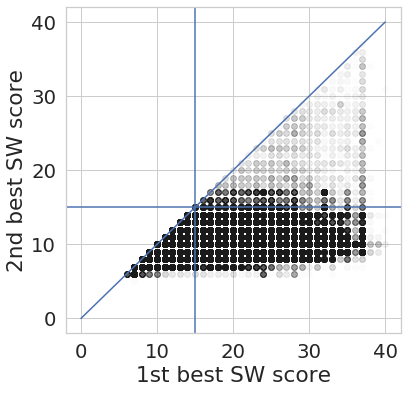

In [74]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(max_sw, second_best_sw, alpha=0.01, c="k")
ax.set_title("")
ax.set_xlabel("1st best SW score")
ax.set_ylabel("2nd best SW score")
ax.plot([0, 40], [0, 40])
ax.axhline(15)
ax.axvline(15)

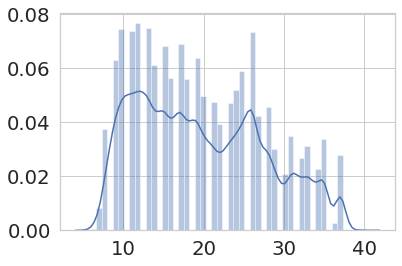

In [75]:
sns.distplot(max_sw)

### Merge & save alignment scores for all fq files

In [76]:
sw_tsv

'/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/fastq_runid_e33d821ff769cbb24ed5af866a50887f3e1ea5c3_80_3.tsv'

In [60]:
run_id = re.findall(r"all_(.*).tsv", sw_tsv)[0]

In [77]:
merged_sw_file = os.path.join(sw_dir, f"all_{run_id}.tsv")

In [78]:
sw.to_csv(merged_sw_file, sep="\t", index=True)

In [79]:
merged_sw_file

'/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_02_exec_20190815/sw/all_e33d821ff769cbb24ed5af866a50887f3e1ea5c3.tsv'

# Evaluate extant molbits vs rest

## Specify which molbits were actually present

In [80]:
# Create set_N variables based on spreadsheet
molbit_sets = {}
for ix, row in set_spreadsheet.iterrows():
    set_no = re.findall(r"set ([\d]+)", row["set"])[0]
    molbits = row["molbits_in_set"]
    molbit_sets[set_no] = molbits.split(", ")

In [81]:
molbit_set_in_run = str(run_data.get("molbit_set"))
molbit_sets_on_flowcell = run_data.get("prev_on_flowcell")

molbits_in_run = molbit_sets[molbit_set_in_run]
molbits_on_flowcell = molbits_in_run[:]
if molbit_sets_on_flowcell != "none":
    molbit_sets_on_flowcell = molbit_sets_on_flowcell.split(", ")
    for m in molbit_sets_on_flowcell:
        print(m)
        print(molbit_sets[m])
        molbits_on_flowcell.extend(molbit_sets[m])
    print(molbits_on_flowcell)

## Extract the best-aligned molbit, across all 96 molbits

This cell replaces "make_sw_call" in the past. No more "-1"s. Just filter by accept_molbit.

In [82]:
sw_scores = sw.filter(regex="score_molbit_.*")
best_molbits = sw_scores.apply(np.argmax, axis=1)
accept_molbit = sw.lookup(sw.index, best_molbits) >= 15
sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/software/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


In [83]:
len(accept_molbit)

287313

In [84]:
sum(accept_molbit)

195547

In [85]:
sum(accept_molbit) / len(accept_molbit)

0.6806061681859157

## Extract the best-aligned molbit, across ONLY the extant molbits

In [86]:
extant_sw_cols = [f"sw_score_molbit_{molbit}" for molbit in molbits_on_flowcell]

In [87]:
extant_sw = sw.loc[:, extant_sw_cols]

In [88]:
extant_sw_scores = extant_sw.filter(regex="score_molbit_.*")
best_molbits = extant_sw_scores.apply(np.argmax, axis=1)
accept_molbit = extant_sw.lookup(extant_sw.index, best_molbits) >= 15
extant_sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
extant_sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


## Compare 

In [89]:
# Only retrieve high-scoring alignments
sw_accepted = sw[sw["accept_molbit"]]
extant_sw_acc = extant_sw[sw["accept_molbit"]]

In [90]:
n_extant_is_best = sum(extant_sw_acc["best_molbit"] == sw_accepted["best_molbit"])

In [91]:
n_extant_is_best

194460

Percentage of well-aligned reads that belong to the true set

In [92]:
n_extant_is_best/len(sw_accepted)

0.9944412340767181

Read counts for each molbit

In [93]:
m, c = np.unique(extant_sw_acc["best_molbit"], return_counts=True)
list(zip(m, c))

[('64', 306),
 ('65', 7074),
 ('66', 35867),
 ('67', 8613),
 ('68', 12637),
 ('69', 4146),
 ('70', 3821),
 ('71', 6407),
 ('72', 16971),
 ('73', 8467),
 ('74', 49821),
 ('75', 20108),
 ('76', 1245),
 ('77', 15052),
 ('78', 2112),
 ('79', 2900)]

## Extract the best-aligned molbit, across ONLY the current run's molbits

In [94]:
extant_sw_cols = [f"sw_score_molbit_{molbit}" for molbit in molbits_in_run]

In [95]:
extant_sw = sw.loc[:, extant_sw_cols]

In [96]:
extant_sw_scores = extant_sw.filter(regex="score_molbit_.*")
best_molbits = extant_sw_scores.apply(np.argmax, axis=1)
accept_molbit = extant_sw.lookup(extant_sw.index, best_molbits) >= 15
extant_sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
extant_sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


## Compare 

In [97]:
# Only retrieve high-scoring alignments
sw_accepted = sw[sw["accept_molbit"]]
extant_sw_acc = extant_sw[sw["accept_molbit"]]

In [98]:
n_extant_is_best = sum(extant_sw_acc["best_molbit"] == sw_accepted["best_molbit"])

In [99]:
n_extant_is_best

194460

Percentage of well-aligned reads that belong to the true set

In [100]:
n_extant_is_best/len(sw_accepted)

0.9944412340767181

Read counts for each molbit

In [101]:
m, c = np.unique(extant_sw_acc["best_molbit"], return_counts=True)
list(zip(m, c))

[('64', 306),
 ('65', 7074),
 ('66', 35867),
 ('67', 8613),
 ('68', 12637),
 ('69', 4146),
 ('70', 3821),
 ('71', 6407),
 ('72', 16971),
 ('73', 8467),
 ('74', 49821),
 ('75', 20108),
 ('76', 1245),
 ('77', 15052),
 ('78', 2112),
 ('79', 2900)]

In [103]:
print("\n".join([str(x) for x in c]))

306
7074
35867
8613
12637
4146
3821
6407
16971
8467
49821
20108
1245
15052
2112
2900


## Get counts for all molbits

In [104]:
m, c = np.unique(sw[sw["accept_molbit"]]["best_molbit"], return_counts=True)
molbit_counts = dict(zip(m, c))
for i in range(96):
    i = str(i)
    if i in molbit_counts:
        print(f"{molbit_counts[i]}")
    else:
        print(f"0")

0
2
5
0
0
0
0
3
8
16
0
19
1
31
0
6
1
5
0
0
0
0
82
159
0
0
0
0
2
1
7
0
0
2
0
19
84
2
0
0
1
1
8
7
1
0
1
22
0
476
3
0
2
9
1
1
2
0
16
2
0
0
5
2
302
7057
35847
8587
12606
4133
3816
6399
16809
8443
49756
19638
1235
15011
2109
2712
1
0
5
0
0
0
0
1
0
0
2
37
21
0
2
3
